<p align="center">
<img src='https://github.com/manuelmorgado/AQiPT/blob/main/resources/aqipt_logo.png?raw=true' width="400" />
</p>


\textbf{Author}: Manuel A. Morgado V. (morgadovargas@unistra.fr)

\textbf{Affiliation}: 

- \textit{Institut de Science et d’Ingénierie Supramoléculaires (ISIS, UMR7006), University of Strasbourg and CNRS}

- \textit{Centre Européen de Sciences Quantiques (CESQ-ISIS, UMR7006), University of Strasbourg and CNRS}

\textbf{Created}: Oct.04, 2021

\textbf{Last Modification}: Oct.04, 2021

\textbf{License}: http://www.apache.org/licenses/LICENSE-2.0

In [6]:
#libs
import numpy as np
np.seterr(all='raise')
from numpy.linalg import norm

import matplotlib.pyplot as plt

import datetime
import struct
import glob
import time
import os 

from scipy.linalg import solve
import scipy.optimize

import pandas as pd

In [10]:
def setCurrentDir(pathDir):
    os.chdir(pathDir)

In [11]:
directory = "/home/manuel/Github/RydAt-Qcomputer/AQiPT_release_01/notebooks/modules/notebooks-analysis/resources/"; #path directory laptop with current date
setCurrentDir(directory)
os.getcwd()

'/home/manuel/Github/RydAt-Qcomputer/AQiPT_release_01/notebooks/modules/notebooks-analysis/resources'

# Importing data from spreadsheet e.g., Excel or LibreOffice Calc

In [108]:
def SPREADSHEET2array(fname_lst:list, hnames=None):
    '''
    Example:
    
        fname_lst = ['spectroscopy.ods']
        data_spreadsheet = SPREADSHEET2array(fname_lst)

        plt.plot(data_spreadsheet.reshape((61, 2))[:, 0:1], data_spreadsheet.reshape((61, 2))[:, 1:2])
    '''
    for fname in fname_lst:
        pframe = pd.read_excel(open(fname,'rb'), 
                               header=None,
                               sheet_name='Sheet1');
        if hnames == None:
            pframe.columns = ['xValues', 'yValues'];
        else:
            pframe.columns = hnames;

    return pframe.to_numpy()


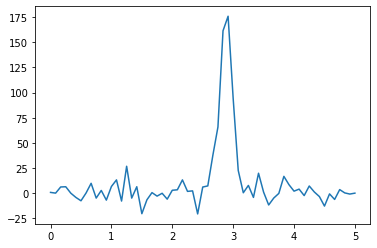

In [98]:
fname_lst = ['spectroscopy.ods']
data_spreadsheet = SPREADSHEET2array(fname_lst)

plt.figure()
plt.plot(data_spreadsheet.reshape((61, 2))[:, 0:1], data_spreadsheet.reshape((61, 2))[:, 1:2])

In [137]:
def CSV2array(filename, pathDir=None, hnames=None):
    '''
    Example:
        pdCSVextract(filename[i]+'.csv', pathDir=None)
    '''
    pframe = pd.read_csv(filename, header=hnames, converters={i: str for i in range(50)})
    return np.asarray([float(i) for i in pframe.to_numpy()])

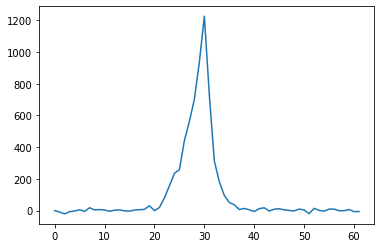

In [142]:
fname = 'Efield.csv'
data_csv = CSV2array(fname, pathDir=None)

plt.figure()
plt.plot(data_csv)

In [143]:
def PRN2array(filename, delim=',', nr_cols=2):
    '''
        xs, ys = fromPrn('multiplexing.prn')
    '''
    metadata = np.genfromtxt(filename, delimiter=delim, usecols=np.arange(0,nr_cols))
    metadata = metadata[2:]
    xValues=[]; yValues=[];
    for i in range(len(metadata)):
        xValues.append(metadata[i][0])
        yValues.append(metadata[i][1])
    return np.asarray(xValues), np.asarray(yValues)



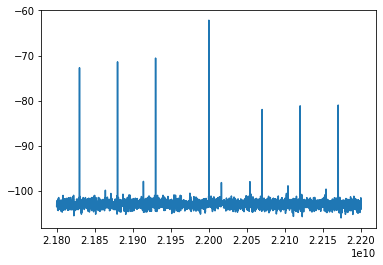

In [146]:
fname = 'multiplexing.prn'
xs, ys = PRN2array(fname)

plt.figure()
plt.plot(xs, ys)

In [157]:
class Trc:
    '''
         Little helper class to load data from a .trc binary file.
        This is the file format used by LeCroy oscilloscopes.
        M. Betz 09/2015
    '''
    _recTypes = (
        "single_sweep", "interleaved", "histogram", "graph",
        "filter_coefficient", "complex", "extrema",
        "sequence_obsolete", "centered_RIS", "peak_detect"
    )
    _processings = (
        "no_processing", "fir_filter", "interpolated", "sparsed",
        "autoscaled", "no_result", "rolling", "cumulative"
    )
    _timebases = (
        '1_ps/div', '2_ps/div', '5_ps/div', '10_ps/div', '20_ps/div',
        '50_ps/div', '100_ps/div', '200_ps/div', '500_ps/div', '1_ns/div',
        '2_ns/div', '5_ns/div', '10_ns/div', '20_ns/div', '50_ns/div',
        '100_ns/div', '200_ns/div', '500_ns/div', '1_us/div', '2_us/div',
        '5_us/div', '10_us/div', '20_us/div', '50_us/div', '100_us/div',
        '200_us/div', '500_us/div', '1_ms/div', '2_ms/div', '5_ms/div',
        '10_ms/div', '20_ms/div', '50_ms/div', '100_ms/div', '200_ms/div',
        '500_ms/div', '1_s/div', '2_s/div', '5_s/div', '10_s/div',
        '20_s/div', '50_s/div', '100_s/div', '200_s/div', '500_s/div',
        '1_ks/div', '2_ks/div', '5_ks/div', 'EXTERNAL'
    )
    _vCouplings = ('DC_50_Ohms', 'ground', 'DC_1MOhm', 'ground', 'AC,_1MOhm')
    _vGains = (
        '1_uV/div', '2_uV/div', '5_uV/div', '10_uV/div', '20_uV/div',
        '50_uV/div', '100_uV/div', '200_uV/div', '500_uV/div', '1_mV/div',
        '2_mV/div', '5_mV/div', '10_mV/div', '20_mV/div', '50_mV/div',
        '100_mV/div', '200_mV/div', '500_mV/div', '1_V/div', '2_V/div',
        '5_V/div', '10_V/div', '20_V/div', '50_V/div', '100_V/div',
        '200_V/div', '500_V/div', '1_kV/div'
    )

    def __init__(self):
        """
        use trc.open(fName) to open a Le Croy .trc file
        """
        self._f = None
        # offset to start of WAVEDESC block
        self._offs = 0
        self._smplFmt = "int16"
        self._endi = ""

    def open(self, fName):
        """
            _readS .trc binary files from LeCroy Oscilloscopes.
            Decoding is based on LECROY_2_3 template.
            [More info]
            (http://forums.ni.com/attachments/ni/60/4652/2/LeCroyWaveformTemplate_2_3.pdf)

            Parameters
            -----------
            fName = filename of the .trc file

            Returns
            -----------
            a tuple (x, y, d)

            x: array with sample times [s],

            y: array with sample  values [V],

            d: dictionary with metadata

            M. Betz 09/2015
        """
        with open(fName, "rb") as f:
            # Binary file handle
            self._f = f
            self._endi = ""
            temp = f.read(64)
            # offset to start of WAVEDESC block
            self._offs = temp.find(b'WAVEDESC')

            # -------------------------------
            #  Read WAVEDESC block
            # -------------------------------
            # Template name
            self._TEMPLATE_NAME = self._readS("16s", 16)
            if self._TEMPLATE_NAME != "LECROY_2_3":
                print(
                    "Warning, unsupported file template:",
                    self._TEMPLATE_NAME,
                    "... trying anyway"
                )
            # 16 or 8 bit sample format?
            if self._readX('H', 32):
                self._smplFmt = "int16"
            else:
                self._smplFmt = "int8"
            # Endian-ness ("<" or ">")
            if self._readX('H', 34):
                self._endi = "<"
            else:
                self._endi = ">"
            #  Get length of blocks and arrays
            self._lWAVE_DESCRIPTOR = self._readX("l", 36)
            self._lUSER_TEXT = self._readX("l", 40)
            self._lTRIGTIME_ARRAY = self._readX("l", 48)
            self._lRIS_TIME_ARRAY = self._readX("l", 52)
            self._lWAVE_ARRAY_1 = self._readX("l", 60)
            self._lWAVE_ARRAY_2 = self._readX("l", 64)

            d = dict()  # Will store all the extracted Metadata

            # ------------------------
            #  Get Instrument info
            # ------------------------
            d["INSTRUMENT_NAME"] = self._readS("16s", 76)
            d["INSTRUMENT_NUMBER"] = self._readX("l", 92)
            d["TRACE_LABEL"] = self._readS("16s", 96)

            # ------------------------
            #  Get Waveform info
            # ------------------------
            d["WAVE_ARRAY_COUNT"] = self._readX("l", 116)
            d["PNTS_PER_SCREEN"] = self._readX("l", 120)
            d["FIRST_VALID_PNT"] = self._readX("l", 124)
            d["LAST_VALID_PNT"] = self._readX("l", 128)
            d["FIRST_POINT"] = self._readX("l", 132)
            d["SPARSING_FACTOR"] = self._readX("l", 136)
            d["SEGMENT_INDEX"] = self._readX("l", 140)
            d["SUBARRAY_COUNT"] = self._readX("l", 144)
            d["SWEEPS_PER_ACQ"] = self._readX("l", 148)
            d["POINTS_PER_PAIR"] = self._readX("h", 152)
            d["PAIR_OFFSET"] = self._readX("h", 154)
            d["VERTICAL_GAIN"] = self._readX("f", 156)
            d["VERTICAL_OFFSET"] = self._readX("f", 160)
            # to get floating values from raw data:
            # VERTICAL_GAIN * data - VERTICAL_OFFSET
            d["MAX_VALUE"] = self._readX("f", 164)
            d["MIN_VALUE"] = self._readX("f", 168)
            d["NOMINAL_BITS"] = self._readX("h", 172)
            d["NOM_SUBARRAY_COUNT"] = self._readX("h", 174)
            # sampling interval for time domain waveforms
            d["HORIZ_INTERVAL"] = self._readX("f", 176)
            # trigger offset for the first sweep of the trigger,
            # seconds between the trigger and the first data point
            d["HORIZ_OFFSET"] = self._readX("d", 180)
            d["PIXEL_OFFSET"] = self._readX("d", 188)
            d["VERTUNIT"] = self._readS("48s", 196)
            d["HORUNIT"] = self._readS("48s", 244)
            d["HORIZ_UNCERTAINTY"] = self._readX("f", 292)
            d["TRIGGER_TIME"] = self._getTimeStamp(296)
            d["ACQ_DURATION"] = self._readX("f", 312)
            d["RECORD_TYPE"] = Trc._recTypes[
                self._readX("H", 316)
            ]
            d["PROCESSING_DONE"] = Trc._processings[
                self._readX("H", 318)
            ]
            d["RIS_SWEEPS"] = self._readX("h", 322)
            d["TIMEBASE"] = Trc._timebases[self._readX("H", 324)]
            d["VERT_COUPLING"] = Trc._vCouplings[
                self._readX("H", 326)
            ]
            d["PROBE_ATT"] = self._readX("f", 328)
            d["FIXED_VERT_GAIN"] = Trc._vGains[
                self._readX("H", 332)
            ]
            d["BANDWIDTH_LIMIT"] = bool(self._readX("H", 334))
            d["VERTICAL_VERNIER"] = self._readX("f", 336)
            d["ACQ_VERT_OFFSET"] = self._readX("f", 340)
            d["WAVE_SOURCE"] = self._readX("H", 344)
            d["USER_TEXT"] = self._readS(
                "{0}s".format(self._lUSER_TEXT),
                self._lWAVE_DESCRIPTOR
            )

            y = self._readSamples()
            y = d["VERTICAL_GAIN"] * y - d["VERTICAL_OFFSET"]
            x = np.arange(1, len(y) + 1, dtype=float)
            x *= d["HORIZ_INTERVAL"]
            x += d["HORIZ_OFFSET"]
        self.f = None
        self.x = x
        self.y = y
        self.d = d
        return x, y, d

    def _readX(self, fmt, adr=None):
        """ extract a byte / word / float / double from the binary file f """
        fmt = self._endi + fmt
        nBytes = struct.calcsize(fmt)
        if adr is not None:
            self._f.seek(adr + self._offs)
        s = struct.unpack(fmt, self._f.read(nBytes))
        if(type(s) == tuple):
            return s[0]
        else:
            return s

    def _readS(self, fmt="16s", adr=None):
        """ read (and decode) a fixed length string """
        temp = self._readX(fmt, adr).split(b'\x00')[0]
        return temp.decode()

    def _readSamples(self):
        # ------------------------
        #  Get main sample data with the help of numpys .fromfile(
        # ------------------------
        # Seek to WAVE_ARRAY_1
        self._f.seek(
            self._offs + self._lWAVE_DESCRIPTOR +
            self._lUSER_TEXT + self._lTRIGTIME_ARRAY +
            self._lRIS_TIME_ARRAY
        )
        y = np.fromfile(self._f, self._smplFmt, self._lWAVE_ARRAY_1)
        if self._endi == ">":
            y.byteswap(True)
        return y

    def _getTimeStamp(self, adr):
        """ extract a timestamp from the binary file """
        s = self._readX("d", adr)
        m = self._readX("b")
        h = self._readX("b")
        D = self._readX("b")
        M = self._readX("b")
        Y = self._readX("h")
        trigTs = datetime.datetime(
            Y, M, D, h, m, int(s), int((s - int(s)) * 1e6)
        )
        return trigTs
    
def fromTRC(filename, Ntrace, roi):
    '''
    \example
    dataset = importTr('C2--trace_data.trc', 200, (8500, 11000))

    '''
        # trc = Trc()
    datX, datY, m = Trc().open(filename)
    datY2 = datY.reshape(Ntrace, int(datY.size/Ntrace))
    datY2 = (-datY2[:, roi[0]:roi[1]])[0]
    return datY2



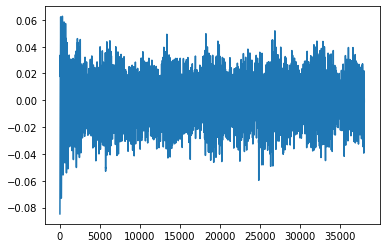

In [159]:
fname = 'ion_trace.trc'
RIO = (1, 38002)
nrTraces = 1
data_trc = fromTRC(fname, nrTraces, RIO)

plt.figure()
plt.plot(data_trc)

# Class ```importData()```


In [ ]:
class importData:
     """
        A class for importing data from many formats and keeping a detailed metadata format for internal or
        future use within and out of AQiPT.

        The importData class is compatible with several formats, new ones can be added whenever mantain structure.


        Parameters
        ----------
        tbase : array_like
            Data for vector/matrix representation of the quantum object.
        res : list
            Dimensions of object used for tensor products.
        args : list
            Shape of underlying data structure (matrix shape).

        Attributes
        ----------
        function : array_like
            Sparse matrix characterizing the quantum object.
        function_plot : list
            List of dimensions keeping track of the tensor structure.

        Methods
        -------
        step()
            Conjugate of quantum object.
    """
    def __init__(self, times):
        
        #atributes
        self.data = None
        self._filename = None
        self._format = None
        self._instrument = None
        self._date = None
        self.comments = None

    
    def SPREADSHEET2array(self, fname, hnames=None, comments=None):
        '''
            Example:

                fname_lst = ['spectroscopy.ods']
                data_spreadsheet = SPREADSHEET2array(fname_lst)

                plt.plot(data_spreadsheet.reshape((61, 2))[:, 0:1], data_spreadsheet.reshape((61, 2))[:, 1:2])
        '''

        pframe = pd.read_excel(open(fname,'rb'), 
                               header=hnames,
                               sheet_name='Sheet1');
        if hnames == None:
            pframe.columns = ['xValues', 'yValues'];
        else:
            pframe.columns = hnames;

        self.data = pframe.to_numpy()
        self._filename = fname
        self._format = 'excel'
        self.date = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
        self.comments = comments
    
    def CSV2array(self, fname, hnames=None, comments=None):
        '''
            Example:
                pdCSVextract(filename[i]+'.csv', pathDir=None)
        '''
        pframe = pd.read_csv(fname, header=hnames, converters={i: str for i in range(50)})
    
        self.data = np.asarray([float(i) for i in pframe.to_numpy()])
        self._filename = fname
        self._format = '.csv'
        self.date = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
        self.comments = comments
        
    def PRN2array(fname, delim=',', nr_cols=2):
        '''
            xs, ys = fromPrn('multiplexing.prn')
        '''
        metadata = np.genfromtxt(fname, delimiter=delim, usecols=np.arange(0,nr_cols))
        metadata = metadata[2:]
        xValues=[]; yValues=[];
        for i in range(len(metadata)):
            xValues.append(metadata[i][0])
            yValues.append(metadata[i][1])
        
        self.data = np.asarray(xValues), np.asarray(yValues)
        self._filename = fname
        self._format = '.prn'
        self.date = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
        self.comments = comments
        
    class Trc:
        '''
             Little helper class to load data from a .trc binary file.
            This is the file format used by LeCroy oscilloscopes.
            M. Betz 09/2015
        '''
        _recTypes = (
            "single_sweep", "interleaved", "histogram", "graph",
            "filter_coefficient", "complex", "extrema",
            "sequence_obsolete", "centered_RIS", "peak_detect"
        )
        _processings = (
            "no_processing", "fir_filter", "interpolated", "sparsed",
            "autoscaled", "no_result", "rolling", "cumulative"
        )
        _timebases = (
            '1_ps/div', '2_ps/div', '5_ps/div', '10_ps/div', '20_ps/div',
            '50_ps/div', '100_ps/div', '200_ps/div', '500_ps/div', '1_ns/div',
            '2_ns/div', '5_ns/div', '10_ns/div', '20_ns/div', '50_ns/div',
            '100_ns/div', '200_ns/div', '500_ns/div', '1_us/div', '2_us/div',
            '5_us/div', '10_us/div', '20_us/div', '50_us/div', '100_us/div',
            '200_us/div', '500_us/div', '1_ms/div', '2_ms/div', '5_ms/div',
            '10_ms/div', '20_ms/div', '50_ms/div', '100_ms/div', '200_ms/div',
            '500_ms/div', '1_s/div', '2_s/div', '5_s/div', '10_s/div',
            '20_s/div', '50_s/div', '100_s/div', '200_s/div', '500_s/div',
            '1_ks/div', '2_ks/div', '5_ks/div', 'EXTERNAL'
        )
        _vCouplings = ('DC_50_Ohms', 'ground', 'DC_1MOhm', 'ground', 'AC,_1MOhm')
        _vGains = (
            '1_uV/div', '2_uV/div', '5_uV/div', '10_uV/div', '20_uV/div',
            '50_uV/div', '100_uV/div', '200_uV/div', '500_uV/div', '1_mV/div',
            '2_mV/div', '5_mV/div', '10_mV/div', '20_mV/div', '50_mV/div',
            '100_mV/div', '200_mV/div', '500_mV/div', '1_V/div', '2_V/div',
            '5_V/div', '10_V/div', '20_V/div', '50_V/div', '100_V/div',
            '200_V/div', '500_V/div', '1_kV/div'
        )

        def __init__(self):
            """
            use trc.open(fName) to open a Le Croy .trc file
            """
            self._f = None
            # offset to start of WAVEDESC block
            self._offs = 0
            self._smplFmt = "int16"
            self._endi = ""

        def open(self, fName):
            """
                _readS .trc binary files from LeCroy Oscilloscopes.
                Decoding is based on LECROY_2_3 template.
                [More info]
                (http://forums.ni.com/attachments/ni/60/4652/2/LeCroyWaveformTemplate_2_3.pdf)

                Parameters
                -----------
                fName = filename of the .trc file

                Returns
                -----------
                a tuple (x, y, d)

                x: array with sample times [s],

                y: array with sample  values [V],

                d: dictionary with metadata

                M. Betz 09/2015
            """
            with open(fName, "rb") as f:
                # Binary file handle
                self._f = f
                self._endi = ""
                temp = f.read(64)
                # offset to start of WAVEDESC block
                self._offs = temp.find(b'WAVEDESC')

                # -------------------------------
                #  Read WAVEDESC block
                # -------------------------------
                # Template name
                self._TEMPLATE_NAME = self._readS("16s", 16)
                if self._TEMPLATE_NAME != "LECROY_2_3":
                    print(
                        "Warning, unsupported file template:",
                        self._TEMPLATE_NAME,
                        "... trying anyway"
                    )
                # 16 or 8 bit sample format?
                if self._readX('H', 32):
                    self._smplFmt = "int16"
                else:
                    self._smplFmt = "int8"
                # Endian-ness ("<" or ">")
                if self._readX('H', 34):
                    self._endi = "<"
                else:
                    self._endi = ">"
                #  Get length of blocks and arrays
                self._lWAVE_DESCRIPTOR = self._readX("l", 36)
                self._lUSER_TEXT = self._readX("l", 40)
                self._lTRIGTIME_ARRAY = self._readX("l", 48)
                self._lRIS_TIME_ARRAY = self._readX("l", 52)
                self._lWAVE_ARRAY_1 = self._readX("l", 60)
                self._lWAVE_ARRAY_2 = self._readX("l", 64)

                d = dict()  # Will store all the extracted Metadata

                # ------------------------
                #  Get Instrument info
                # ------------------------
                d["INSTRUMENT_NAME"] = self._readS("16s", 76)
                d["INSTRUMENT_NUMBER"] = self._readX("l", 92)
                d["TRACE_LABEL"] = self._readS("16s", 96)

                # ------------------------
                #  Get Waveform info
                # ------------------------
                d["WAVE_ARRAY_COUNT"] = self._readX("l", 116)
                d["PNTS_PER_SCREEN"] = self._readX("l", 120)
                d["FIRST_VALID_PNT"] = self._readX("l", 124)
                d["LAST_VALID_PNT"] = self._readX("l", 128)
                d["FIRST_POINT"] = self._readX("l", 132)
                d["SPARSING_FACTOR"] = self._readX("l", 136)
                d["SEGMENT_INDEX"] = self._readX("l", 140)
                d["SUBARRAY_COUNT"] = self._readX("l", 144)
                d["SWEEPS_PER_ACQ"] = self._readX("l", 148)
                d["POINTS_PER_PAIR"] = self._readX("h", 152)
                d["PAIR_OFFSET"] = self._readX("h", 154)
                d["VERTICAL_GAIN"] = self._readX("f", 156)
                d["VERTICAL_OFFSET"] = self._readX("f", 160)
                # to get floating values from raw data:
                # VERTICAL_GAIN * data - VERTICAL_OFFSET
                d["MAX_VALUE"] = self._readX("f", 164)
                d["MIN_VALUE"] = self._readX("f", 168)
                d["NOMINAL_BITS"] = self._readX("h", 172)
                d["NOM_SUBARRAY_COUNT"] = self._readX("h", 174)
                # sampling interval for time domain waveforms
                d["HORIZ_INTERVAL"] = self._readX("f", 176)
                # trigger offset for the first sweep of the trigger,
                # seconds between the trigger and the first data point
                d["HORIZ_OFFSET"] = self._readX("d", 180)
                d["PIXEL_OFFSET"] = self._readX("d", 188)
                d["VERTUNIT"] = self._readS("48s", 196)
                d["HORUNIT"] = self._readS("48s", 244)
                d["HORIZ_UNCERTAINTY"] = self._readX("f", 292)
                d["TRIGGER_TIME"] = self._getTimeStamp(296)
                d["ACQ_DURATION"] = self._readX("f", 312)
                d["RECORD_TYPE"] = Trc._recTypes[
                    self._readX("H", 316)
                ]
                d["PROCESSING_DONE"] = Trc._processings[
                    self._readX("H", 318)
                ]
                d["RIS_SWEEPS"] = self._readX("h", 322)
                d["TIMEBASE"] = Trc._timebases[self._readX("H", 324)]
                d["VERT_COUPLING"] = Trc._vCouplings[
                    self._readX("H", 326)
                ]
                d["PROBE_ATT"] = self._readX("f", 328)
                d["FIXED_VERT_GAIN"] = Trc._vGains[
                    self._readX("H", 332)
                ]
                d["BANDWIDTH_LIMIT"] = bool(self._readX("H", 334))
                d["VERTICAL_VERNIER"] = self._readX("f", 336)
                d["ACQ_VERT_OFFSET"] = self._readX("f", 340)
                d["WAVE_SOURCE"] = self._readX("H", 344)
                d["USER_TEXT"] = self._readS(
                    "{0}s".format(self._lUSER_TEXT),
                    self._lWAVE_DESCRIPTOR
                )

                y = self._readSamples()
                y = d["VERTICAL_GAIN"] * y - d["VERTICAL_OFFSET"]
                x = np.arange(1, len(y) + 1, dtype=float)
                x *= d["HORIZ_INTERVAL"]
                x += d["HORIZ_OFFSET"]
            self.f = None
            self.x = x
            self.y = y
            self.d = d
            return x, y, d

        def _readX(self, fmt, adr=None):
            """ extract a byte / word / float / double from the binary file f """
            fmt = self._endi + fmt
            nBytes = struct.calcsize(fmt)
            if adr is not None:
                self._f.seek(adr + self._offs)
            s = struct.unpack(fmt, self._f.read(nBytes))
            if(type(s) == tuple):
                return s[0]
            else:
                return s

        def _readS(self, fmt="16s", adr=None):
            """ read (and decode) a fixed length string """
            temp = self._readX(fmt, adr).split(b'\x00')[0]
            return temp.decode()

        def _readSamples(self):
            # ------------------------
            #  Get main sample data with the help of numpys .fromfile(
            # ------------------------
            # Seek to WAVE_ARRAY_1
            self._f.seek(
                self._offs + self._lWAVE_DESCRIPTOR +
                self._lUSER_TEXT + self._lTRIGTIME_ARRAY +
                self._lRIS_TIME_ARRAY
            )
            y = np.fromfile(self._f, self._smplFmt, self._lWAVE_ARRAY_1)
            if self._endi == ">":
                y.byteswap(True)
            return y

        def _getTimeStamp(self, adr):
            """ extract a timestamp from the binary file """
            s = self._readX("d", adr)
            m = self._readX("b")
            h = self._readX("b")
            D = self._readX("b")
            M = self._readX("b")
            Y = self._readX("h")
            trigTs = datetime.datetime(
                Y, M, D, h, m, int(s), int((s - int(s)) * 1e6)
            )
            return trigTs

        def fromTRC(filename, Ntrace, roi):
            '''
            \example
            dataset = importTr('C2--trace_data.trc', 200, (8500, 11000))

            '''
                # trc = Trc()
            datX, datY, m = Trc().open(filename)
            datY2 = datY.reshape(Ntrace, int(datY.size/Ntrace))
            datY2 = (-datY2[:, roi[0]:roi[1]])[0]
            return datY2

